* [About this Dataset](#about)
* [EDA](#eda)
* [Data preparation](#dataprep)
* [Modeling](#modeling)
    * [Meta Learners](#metalearners)
        * [T-Learners](#tlearners)
        * [S-Learners](#slearners)
    * [Uplift Trees](#utrees)
* [Conclusions](#conclusions)

# About this Dataset <a class="anchor" id="about"></a>

  The dataset was created by The Criteo AI Lab .The dataset consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions). Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks). The global treatment ratio is 84.6%. It is usual that advertisers keep only a small control population as it costs them in potential revenue.  
  
Following is a detailed description of the features:  
  
- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
- treatment: treatment group (1 = treated, 0 = control)
- conversion: whether a conversion occured for this user (binary, label)
- visit: whether a visit occured for this user (binary, label)
- exposure: treatment effect, whether the user has been effectively exposed (binary)

In [63]:
!pip install causalml

In [64]:
!pip install scikit-uplift

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

In [66]:
df = pd.read_csv('../input/uplift-modeling/criteo-uplift-v2.1.csv')
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


# EDA <a class="anchor" id="eda"></a>

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [68]:
df.isnull().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [69]:
df.describe().round(2)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00
mean,19.62,10.07,8.45,4.18,10.34,4.03,-4.16,5.10,3.93,16.03,5.33,-0.17,0.85,0.00,0.05,0.03
std,5.38,0.10,0.30,1.34,0.34,0.43,4.58,1.21,0.06,7.02,0.17,0.02,0.36,0.05,0.21,0.17
min,12.62,10.06,8.21,-8.40,10.28,-9.01,-31.43,4.83,3.64,13.19,5.30,-1.38,0.00,0.00,0.00,0.00
25%,12.62,10.06,8.21,4.68,10.28,4.12,-6.70,4.83,3.91,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
50%,21.92,10.06,8.21,4.68,10.28,4.12,-2.41,4.83,3.97,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
75%,24.44,10.06,8.72,4.68,10.28,4.12,0.29,4.83,3.97,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
max,26.75,16.34,9.05,4.68,21.12,4.12,0.29,12.00,3.97,75.30,6.47,-0.17,1.00,1.00,1.00,1.00


In [70]:
def share_pivot(df, index_cols):
    pivot = pd.DataFrame(df[index_cols].value_counts()).sort_index()
    pivot.columns = ['#']
    pivot['share'] = np.round(pivot['#'] / len(df), 2)
    display(pivot)

In [71]:
share_pivot(df = df, index_cols = ['treatment', 'conversion', 'visit', 'exposure'])

#  share
treatment conversion visit exposure                 
0         0          0     0          2016832   0.14
                     1     0            76042   0.01
          1          1     0             4063   0.00
1         0          0     0         11055129   0.79
                           1           250702   0.02
                     1     0           385634   0.03
                           1           154479   0.01
          1          1     0            13680   0.00
                           1            23031   0.00

In [72]:
share_pivot(df = df, index_cols = ['treatment', 'exposure'])

#  share
treatment exposure                 
0         0          2096937   0.15
1         0         11454443   0.82
          1           428212   0.03

In [73]:
share_pivot(df = df, index_cols = ['treatment', 'conversion'])

#  share
treatment conversion                 
0         0            2092874   0.15
          1               4063   0.00
1         0           11845944   0.85
          1              36711   0.00

In [74]:
share_pivot(df = df, index_cols = ['treatment', 'visit'])

#  share
treatment visit                 
0         0       2016832   0.14
          1         80105   0.01
1         0      11305831   0.81
          1        576824   0.04

# Data preparation <a class="anchor" id="dataprep"></a>

In [75]:
train, test = train_test_split(
    df.drop(columns = ['conversion', 'exposure']),
    test_size = 0.4, 
    random_state = 1
)

In [76]:
class DataUndersampler:
    """Makes dataframe balances by target columns within treatment groups"""
    
    def __init__(self, target_column):
        self.__target_column = target_column
    
    def __make_equal(self, df):
        target_0_count = np.sum(df[self.__target_column] == 0)
        target_1_count = np.sum(df[self.__target_column] == 1)
        
        if target_0_count == target_1_count:
            pass
        elif target_0_count > target_1_count:
            df = pd.concat([
                df[df[self.__target_column] == 0].sample(n = target_1_count, random_state = 1),
                df[df[self.__target_column] == 1]
            ], axis = 0)
        elif target_0_count < target_1_count:
            df = pd.concat([
                df[df[self.__target_column] == 0],
                df[df[self.__target_column] == 1].sample(n = target_0_count, random_state = 1)
            ], axis = 0)
        
        return df
    
    def transform(self, df):
        df_treatment_0 = df[df['treatment'] == 0].copy()
        df_treatment_1 = df[df['treatment'] == 1].copy()
        
        df_treatment_0 = self.__make_equal(df_treatment_0)
        df_treatment_1 = self.__make_equal(df_treatment_1)
        df = pd.concat([df_treatment_0, df_treatment_1], axis = 0)
        return df
        
    __call__ = transform

In [77]:
train_us = DataUndersampler(target_column = 'visit')(train)
del train, df

In [78]:
share_pivot(df = train_us, index_cols = ['treatment', 'visit'])

#  share
treatment visit               
0         0       48103   0.06
          1       48103   0.06
1         0      346248   0.44
          1      346248   0.44

In [79]:
train_us.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,visit
5875256,25.624214,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0
13149996,26.356261,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0
10386195,25.777328,10.059654,8.214383,4.679882,10.280525,3.013064,-8.281971,11.883583,3.971858,13.190056,5.300375,-0.168679,0,0
6386357,25.933941,10.059654,8.214383,4.679882,10.280525,4.115453,-16.175537,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0
8503326,17.452438,10.059654,8.214383,3.907662,10.280525,4.115453,-5.987667,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0


In [80]:
X_train = train_us.drop(columns = ['treatment', 'visit'])
treatment_train = train_us['treatment']
y_train = train_us['visit']
X_test = test.drop(columns = ['treatment', 'visit'])
treatment_test = test['treatment']
y_test = test['visit']   

In [81]:
def get_metrics(y_val, uplift_effect, treatment_val):
    no_effect_share = round(100 * np.sum(uplift_effect == 0) / len(uplift_effect), 2)
    positive_effect_share = round(100 * np.sum(uplift_effect > 0) / len(uplift_effect), 2)
    negative_effect_share = round(100 * np.sum(uplift_effect < 0) / len(uplift_effect), 2)
    print(f'Model predicts positive effect in visit probability after treatment for {positive_effect_share}% of cases.')
    print(f'Model predicts negative effect in visit probability after treatment for {negative_effect_share}% of cases.')
    print(f'Model predicts no effect in visit probability after treatment for {no_effect_share}% of cases.')

    upliftk = uplift_at_k(
        y_true = y_val, 
        uplift = uplift_effect, 
        treatment = treatment_val, 
        strategy='by_group', 
        k = 0.3
    )
    
    upliftk_all = uplift_at_k(
        y_true = y_val, 
        uplift = uplift_effect, 
        treatment = treatment_val, 
        strategy = 'overall',
    )

    qini_coef = qini_auc_score(
        y_true = y_val, 
        uplift = uplift_effect,
        treatment = treatment_val
    )

    uplift_auc = uplift_auc_score(
        y_true = y_val, 
        uplift = uplift_effect,
        treatment = treatment_val
    )
    wau = weighted_average_uplift(y_true = y_val, uplift = uplift_effect,
                                  treatment = treatment_val, strategy = 'by_group')
    wau_all = weighted_average_uplift(y_true = y_val, uplift = uplift_effect,
                                  treatment = treatment_val, strategy = 'overall')

    print(f'uplift at top 30% by group: {upliftk:.3f} by overall: {upliftk_all:.3f}\n',
          f'Weighted average uplift by group: {wau:.3f} by overall: {wau_all:.3f}\n',
          f'AUUC by group: {uplift_auc:.3f}\n',
          f'AUQC by group: {qini_coef:.3f}\n')

# Modeling <a class="anchor" id="modeling"></a>

I'm going to model uplift effect just for 'visits' for sake of simplicity

## Meta Learners <a class="anchor" id="metalearners"></a>

### T-Learners <a class="anchor" id="tlearners"></a>

In [82]:
class TLearnerModel:
    
    def __init__(self, classification_model):
        self.model_treatment_0 = clone(classification_model)
        self.model_treatment_1 = clone(classification_model)
    
    def fit(self, X_train, treatment_train, y_train):
        X_train_treatment_0 = X_train[treatment_train == 0]
        y_train_treatment_0 = y_train[treatment_train == 0]
        self.model_treatment_0.fit(X_train_treatment_0, y_train_treatment_0)
        
        X_train_treatment_1 = X_train[treatment_train == 1]
        y_train_treatment_1 = y_train[treatment_train == 1]
        self.model_treatment_1.fit(X_train_treatment_1, y_train_treatment_1)
        
    def predict(self, X_test):
        """return uplift effect array"""
        preds_treatment_0 = self.model_treatment_0.predict_proba(X_test)[:, 1]
        preds_treatment_1 = self.model_treatment_1.predict_proba(X_test)[:, 1]
        return preds_treatment_1 - preds_treatment_0

In [83]:
classification_model = DecisionTreeClassifier(
    random_state = 1, 
    min_samples_leaf = 15
)
ul_model = TLearnerModel(classification_model = classification_model)
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect = ul_model.predict(X_test)
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 30.58% of cases.
Model predicts negative effect in visit probability after treatment for 30.35% of cases.
Model predicts no effect in visit probability after treatment for 39.08% of cases.
uplift at top 30% by group: 0.014 by overall: 0.014
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.005
 AUQC by group: 0.012



Also we can use sklift if reinventing the wheel isn't the goal:

In [84]:
estimator = DecisionTreeClassifier(
    random_state = 1, 
    min_samples_leaf = 15
)

ul_model = TwoModels(clone(estimator), clone(estimator))
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect = ul_model.predict(X_test)
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 43.98% of cases.
Model predicts negative effect in visit probability after treatment for 44.18% of cases.
Model predicts no effect in visit probability after treatment for 11.84% of cases.
uplift at top 30% by group: 0.012 by overall: 0.012
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.004
 AUQC by group: 0.011



In [85]:
estimator = LGBMClassifier(
    random_state = 1,
    n_jobs = -1,
)

ul_model = TwoModels(clone(estimator), clone(estimator))
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect = ul_model.predict(X_test)
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 37.62% of cases.
Model predicts negative effect in visit probability after treatment for 62.38% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: 0.024 by overall: 0.024
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.022
 AUQC by group: 0.056



In [86]:
estimator = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    eval_metric = 'logloss'
)

ul_model = TwoModels(clone(estimator), clone(estimator))
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect = ul_model.predict(X_test)
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 46.61% of cases.
Model predicts negative effect in visit probability after treatment for 53.39% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: 0.021 by overall: 0.021
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.016
 AUQC by group: 0.041



### S-Learner <a class="anchor" id="slearners"></a>

In [87]:
class SLearnerModel:
    
    def __init__(self, classification_model):
        self.model = clone(classification_model)
    
    def fit(self, X_train, treatment_train, y_train):
        X_train['treatment'] = treatment_train
        self.model.fit(X_train, y_train)
        
    def predict(self, X_test):
        """return uplift effect array"""
        X_test_treatment_0 = X_test.copy()
        X_test_treatment_0['treatment'] = 0
        X_test_treatment_1 = X_test.copy()
        del X_test
        X_test_treatment_1['treatment'] = 1
        preds_treatment_0 = self.model.predict_proba(X_test_treatment_0)[:, 1]
        preds_treatment_1 = self.model.predict_proba(X_test_treatment_1)[:, 1]
        return preds_treatment_1 - preds_treatment_0

In [88]:
estimator = DecisionTreeClassifier(
    random_state = 1, 
    min_samples_leaf = 15
)

ul_model = SLearnerModel(estimator)
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect = ul_model.predict(X_test)
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 7.35% of cases.
Model predicts negative effect in visit probability after treatment for 9.06% of cases.
Model predicts no effect in visit probability after treatment for 83.58% of cases.
uplift at top 30% by group: 0.012 by overall: 0.011
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.003
 AUQC by group: 0.008



with sklift:

In [89]:
estimator = DecisionTreeClassifier(
    random_state = 1, 
    min_samples_leaf = 15
)

ul_model = SoloModel(estimator=estimator)
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect = ul_model.predict(X_test)
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 43.56% of cases.
Model predicts negative effect in visit probability after treatment for 44.17% of cases.
Model predicts no effect in visit probability after treatment for 12.27% of cases.
uplift at top 30% by group: 0.011 by overall: 0.011
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.005
 AUQC by group: 0.012



In [90]:
estimator = LGBMClassifier(
    random_state = 1,
    n_jobs = -1,
)

ul_model = SoloModel(estimator=estimator)
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect = ul_model.predict(X_test)
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 29.85% of cases.
Model predicts negative effect in visit probability after treatment for 70.15% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: 0.028 by overall: 0.027
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.031
 AUQC by group: 0.078



In [91]:
estimator = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    eval_metric = 'logloss'
)

ul_model = SoloModel(estimator=estimator)
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect = ul_model.predict(X_test)
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 31.39% of cases.
Model predicts negative effect in visit probability after treatment for 68.46% of cases.
Model predicts no effect in visit probability after treatment for 0.15% of cases.
uplift at top 30% by group: 0.027 by overall: 0.027
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.030
 AUQC by group: 0.077



## Uplift Trees <a class="anchor" id="utrees"></a>

In [92]:
treat_vals_dict = {'0':'control', '1':'treated'}
treatment_train_str = treatment_train.astype('str').map(treat_vals_dict)
treatment_test_str = treatment_test.astype('str').map(treat_vals_dict)
treatment_train_str[:5]

5875256     control
13149996    control
10386195    control
6386357     control
8503326     control
Name: treatment, dtype: object

In [93]:
ul_model = UpliftTreeClassifier(control_name='control', random_state = 1)
ul_model.fit(X_train.values, treatment_train_str.values, y_train.values)
trealment_0_pred = ul_model.predict(X_test.values)[:, 0]
trealment_1_pred = ul_model.predict(X_test.values)[:, 1]
uplift_effect = trealment_1_pred - trealment_0_pred
get_metrics(y_val = y_test, uplift_effect = uplift_effect, treatment_val = treatment_test)

Model predicts positive effect in visit probability after treatment for 18.13% of cases.
Model predicts negative effect in visit probability after treatment for 81.87% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: 0.031 by overall: 0.030
 Weighted average uplift by group: 0.010 by overall: 0.010
 AUUC by group: 0.028
 AUQC by group: 0.073



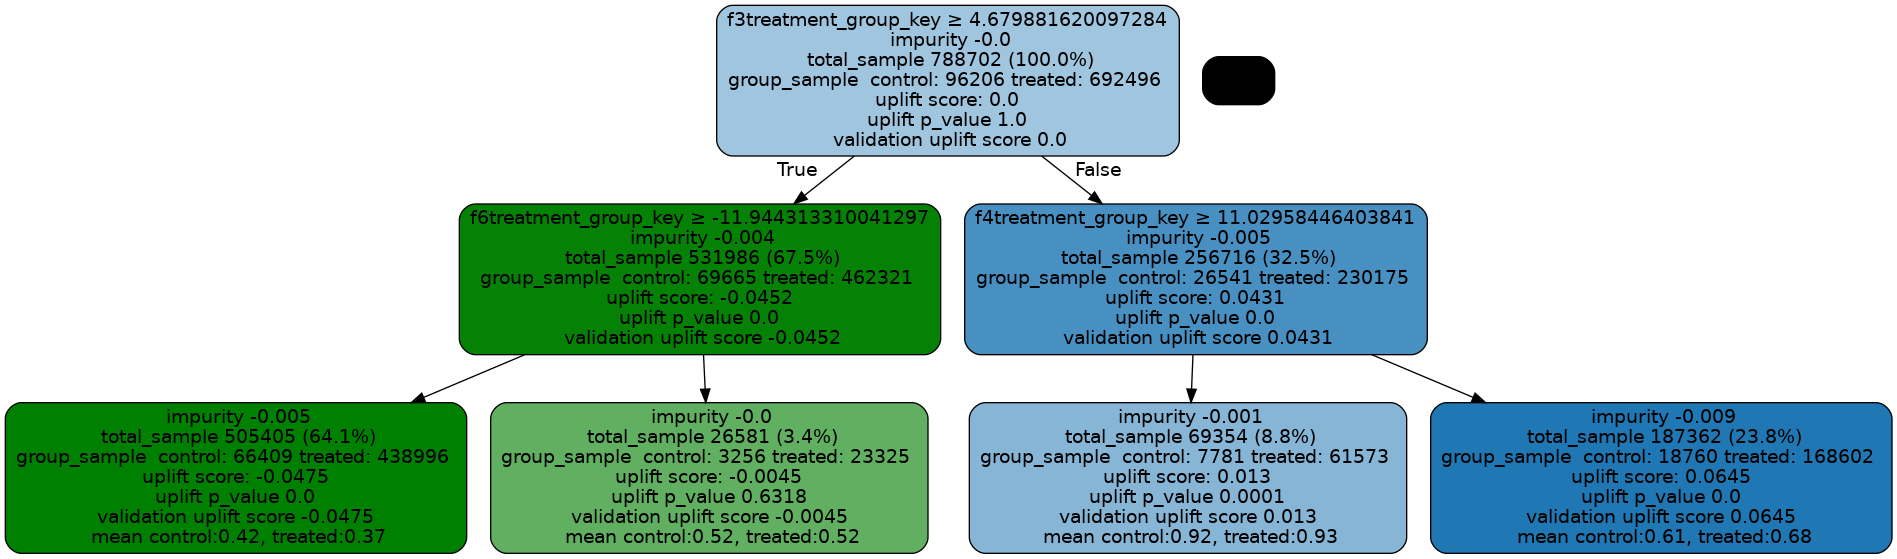

In [94]:
graph = uplift_tree_plot(ul_model.fitted_uplift_tree, X_train.columns)
Image(graph.create_png())

tree interpretion instruction from https://github.com/uber/causalml/blob/master/examples/uplift_tree_visualization.ipynb

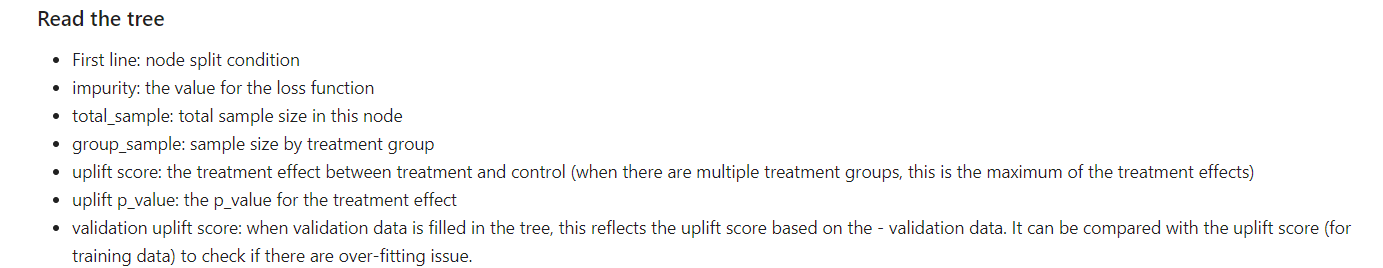

# Conclusions <a class="anchor" id="conclusions"></a>

Looks like the most effective uplift method for this dataset (from tested here) is uplift tree with overall uplift 0.03 (0.031 for top 30%). Among meta learners S-Learners perform better than T-Learners (with a S-Learner based on LGBMClassifier as a leader).